## ECE 6213 - Final Project - Spring 2022

- Osama Yousuf
- Joseph Riem

## End-to-End FPGA Inference

Project Summary:

- Capture an image from the live camera feed via the network interface
    - Our initial idea was to use a USB web camera directly connected to the on-board PS, but we ran into several device configuration issues with the boards and couldn't get the Linux kernel to recognize USB devices directly
    - To circumvent this, we implemented a simple image capturing pipeline over the network.
        - A server runs on any secondary system, which serves the camera feed over an API.
        - The API can be called from the board, and an image can be captured and downloaded in real-time.
- Classify the image by passing it through the neural network running on the PL
    - We pretrained a neural network in software using PyTorch, and exported the network weights
    - Branch 1: We used high-level synthesis tools (hls4ml, to deploy the neural network on the FPGA.
        - The pipeline is as follows:
            - PyTorch Network - 2 layer perceptron network, trained on a reduced MNIST dataset
            - Quantized C-Network (fixed-point precision) generated using hls4ml
            - Equivalent RTL network generated using Vivado HLS 2019.1
        - Once we have the RTL network, we can integrate the IP together in Vivado and create a block diagram that combines the PS-PL on-board I/O with the network. For communication, we implemented a simple DMA channel strategy.
    - Branch 2: Custom RTL.
        - The idea here was to write our own RTL code.
        - Details TBA: @Joseph
        

### Step 1: Real-time Image Capture

Assuming we have a server for the camera feed up and running, we will do the following:
- Connect to the server
- Hit an endpoint that lets us download an image from the web camera in real time

In [2]:
# Send request to the server and download the image locally
import requests

capture_new_image = False

if (capture_new_image):
    # api-endpoint
    URL = "http://192.168.1.152:5000/capture_image"

    # sending get request and saving the response as response object, timeout 3 seconds
    response = requests.get(url = URL, params = None, timeout=3)

    if (response.status_code == 200):
        save_file = open("last_image.jpg", "wb")
        save_file.write(response.content)
        save_file.close()
    else:
        print("Error in sending request to the server. Please check server is running and correct hostname is provided. The last image present on the board will be used if available.") 

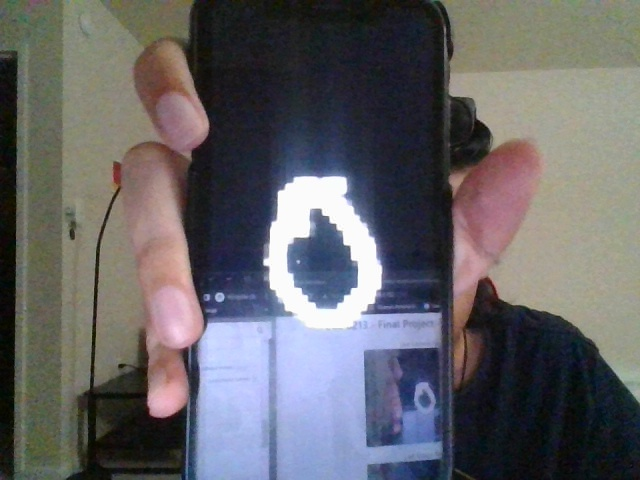

In [3]:
# Display the raw captured image

from IPython.display import Image
Image(filename="last_image.jpg")

**Raw Captured Image**

## Step 2: Image Preprocessing

Now that we have an image from the server, let us prepare it for the network. There's a few things that we need to take care of:

- The image resolution need to be compatible with the input layer of the neural network. In this case, our network supports an input image with a resolution of 18 x 18 pixels.
- The image needs to be localized around the digit. Additionally, the input is binarized (pixels are either a 0, or a 1).
- The image needs to be preprocessed so that it matches the digit representation in the original MNIST dataset on which the network was trained. 

These steps help the network in making a better prediction overall.

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
import ipywidgets as widgets

original_image = None
processed_image = None

@interact(image=fixed('last_image.jpg'), threshold=(1.0, 5.0))
def process_image(image, threshold=1.1):
    # Open the image as grayscale form working directory
    global original_image
    global processed_image
    
    original_image = Image.open(image)

    # Grayscale
    image = original_image.convert('L')

    # Threshold + Binarize
    image = image.point( lambda p: 255 if p > 255 / threshold else 0 )

    # Extract a bounding box and crop
    image = image.crop(image.getbbox())
    
    plt.title("Initial Processing")
    plt.imshow(image, cmap='gray')
    
    processed_image = image

interactive(children=(FloatSlider(value=1.1, description='threshold', max=5.0, min=1.0), Output()), _dom_class…

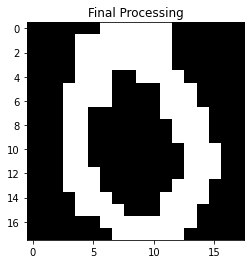

In [5]:
# Now, we need to make image compatible with the network

# First, we ensure that the image is squared

# Helper function, source: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


im_new = expand2square(processed_image, (0))

# Next, we simply resize the image to match the network's expected dimensions
width, height = 18, 18
im_new = im_new.resize((width, height), resample=0)

plt.title("Final Processing")
plt.imshow(im_new, cmap='gray');

## Step 3: Neural Network Inference

Now that we finally have an image compatible with our network, we can now pass it on to the network and extract the network's prediction.

- We program our FPGA using a design that incorporates our neural network IP block.
- The image resides in the PS, and the neural network resides in the PL. For communication, our design uses a DMA interface.
- For input: Our processed image will be placed and sent on a send DMA channel by the PS, and the PL will read this image and pass it onto the neural network through its receive channel. 
- For output: The output vector will be placed by the PL on its send DMA buffer, and the PS will read it and extract the predicted digit by a simple softmax operation.

In [9]:
from drivers.axi_stream_driver import NeuralNetworkOverlay
import numpy as np

X_test = np.asarray(im_new)
X_test[X_test > 0] = 1

nn = NeuralNetworkOverlay('overlays_7z045/hls4ml_16_8_2019_2/nn.bit', X_test.shape, (10,))

print("Overlay loaded!")

y_hw = nn.predict(X_test)
y_hw = np.argmax(y_hw)

print("Predicted Digit is:", y_hw)

nn.axi_gpio_1[0].on()

nn.free()

Overlay loaded!
Predicted Digit is: 0
